In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from hybrid_model_v3 import HybridSegModel

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor

In [10]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [11]:
image_size = 128
batch_size = 1 # if not one, be careful about the zero mask batch
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
tg3k_test_dataset = Gland_Dataset("../gland_data/tg3k_all.csv", transform = test_augmentation, image_size = image_size)
tg3k_test_dataloader = DataLoader(tg3k_test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

benq_test_dataset = Gland_Dataset("../gland_data/crop_benq_all.csv", transform = test_augmentation, image_size = image_size)
benq_test_dataloader = DataLoader(benq_test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask = next(iter(tg3k_test_dataloader))
image, mask = next(iter(benq_test_dataloader))

In [12]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.)
unique :  tensor([0., 1.])


In [13]:
# for i in range(20):
#     plt.subplot(1,2,1)
#     plt.imshow(image[i][0])
#     plt.subplot(1,2,2)
#     plt.imshow(mask[i][0])
#     plt.show()
    

In [14]:
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    dice_arr = []
    count = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 1:2, :, :]
        
        
        loss = loss_fn(output, mask)

        
        IOU = IOU_score(output, mask)


        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
        
        dice_arr.append(DICE.item())

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        count += 1
    return total_loss/count, total_IOU/count, total_DICE/count
    # return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), dice_arr

    

In [15]:
inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
loss_fn = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val = val(tg3k_test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 146/3500 [00:05<02:07, 26.24it/s]


KeyboardInterrupt: 

In [ ]:
loss_fn = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val = val(benq_test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

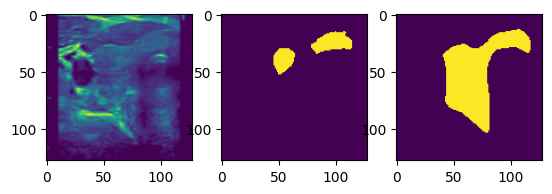

In [24]:
benq_test_dataset = Gland_Dataset("../gland_data/crop_benq_all.csv", transform = test_augmentation, image_size = image_size)
benq_test_dataloader = DataLoader(benq_test_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)
image, mask = next(iter(benq_test_dataloader))
image = image.to("cuda")
outputs = model(image)
        
output = outputs[:, 1:2, :, :]
output = torch.sigmoid(output)
output = output > 0.5

plt.subplot(1,3,1)
plt.imshow(image[0][0].detach().cpu().numpy())
plt.subplot(1,3,2)
plt.imshow(output[0][0].detach().cpu().numpy())
plt.subplot(1,3,3)
plt.imshow(mask[0][0])
plt.show()